In [1]:
import math
import random as r
import matplotlib.pyplot as plt

# background info / review

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

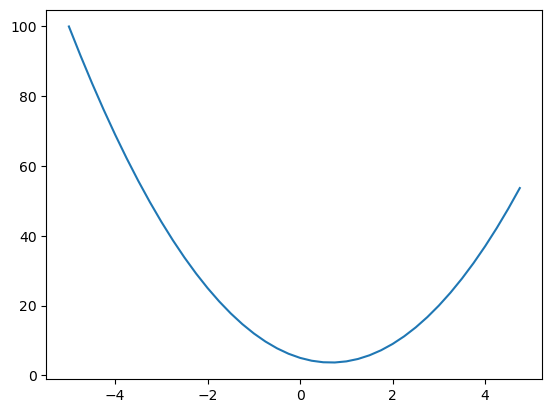

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h

14.00300000000243

# let's build micrograd

## begin building class that keeps track of gradients

In [3]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self): # repr defines how we should print() things
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data)

    def __sub__(self, other):
        return Value(self.data - other.data)

    def __mul__(self, other):
        return Value(self.data * other.data)

    def __truediv__(self, other): # as opposed to __floordiv__ the '//' symbol which is not differentiable
        return Value(self.data / other.data)

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a+b

Value(data=-1.0)

In [5]:
a-c, a.__sub__(c)

(Value(data=-8.0), Value(data=-8.0))

In [7]:
b*c

Value(data=-30.0)

In [9]:
c/a

Value(data=5.0)

## keeping track of the inputs to a value

In [30]:
class Value:
    def __init__(self, data, _children=set(())): 
        self.data = data
        self._prev = _children # set of an empty tuple, aka the empty set

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other): # passing in the values to children so they can be kept track of
        return Value(self.data + other.data, (self, other))

    def __sub__(self, other):
        return Value(self.data - other.data, (self, other))

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other))

    def __truediv__(self, other):
        return Value(self.data / other.data, (self, other))

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
d

Value(data=4.0)

In [13]:
d._prev

(Value(data=-6.0), Value(data=10.0))

In [17]:
d._prev[0]._prev

(Value(data=2.0), Value(data=-3.0))

## adding local gradient info

this is not the actual global gradient that we're interested in; just a precursor concept

In [48]:
class Value:
    def __init__(self, data, _children=set(()), local_grad=0.0): 
        self.data = data
        self._prev = _children
        self.local_grad = local_grad

    def __repr__(self):
        return f"Value(data={self.data}, local_grad={self.local_grad})"

    def __add__(self, other): 
        return Value(self.data + other.data, (self, other), 1)
        # 1 rather than zero bc we're thinking about Value as a variable rather than as a constant

    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), 1)

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), other.data)

    def __truediv__(self, other):
        return Value(self.data / other.data, (self, other), 1/other.data)

In [50]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b # the first letter in the equation is the main character, second is the gradient
e = d + c
f = e / d

print(d, e, f, sep='\n')

Value(data=-6.0, local_grad=-3.0)
Value(data=4.0, local_grad=1)
Value(data=-0.6666666666666666, local_grad=-0.16666666666666666)


## adding tanh nonlinearity

In [38]:
class Value:
    def __init__(self, data, _children=set(()), local_grad=0.0): 
        self.data = data
        self._prev = _children
        self.local_grad = local_grad

    def __repr__(self):
        return f"Value(data={self.data}, local_grad={self.local_grad})"

    def __add__(self, other): 
        return Value(self.data + other.data, (self, other), 1)

    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), 1)

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), other.data)

    def __truediv__(self, other):
        return Value(self.data / other.data, (self, other), 1/other.data)

    def tanh(self):
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        return Value(t, (self, ), 1-t**2) # got that derivative of tanh from wikipedia

In [40]:
# miniature NN
x1, x2 = Value(2.0), Value(0.0)
w1, w2 = Value(-3.0), Value(1.0)
b = Value(6.7)

x1w1, x2w2 = x1*w1, x2*w2
x1w1_plus_x2w2 = x1w1 + x2w2 # aka hidden neuron #1 before the bias & nonlinearity
n = x1w1_plus_x2w2 + b
o = n.tanh()

In [46]:
print(x1w1, x2w2)
print(x1w1_plus_x2w2)
print(n)
print(o)

Value(data=-6.0, local_grad=-3.0) Value(data=0.0, local_grad=1.0)
Value(data=-6.0, local_grad=1)
Value(data=0.7000000000000002, local_grad=1)
Value(data=0.6043677771171636, local_grad=0.6347395899824584)


## all prior labeled grad values were just the local gradients, not the actual backprop grads

In [52]:
class Value:
    def __init__(self, data, _children=()): 
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0 # this no longer means local grad, it'll mean global grad from now on
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other): 
        out = Value(self.data + other.data, (self, other))
        
        def _backward():
            self.grad += out.grad # equivalent to multiplying by 1
            other.grad += out.grad
        # do this instead of _backward() because you just wanna store the funciton, not call it
        out._backward = _backward 
        
        return out

    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other))
        
        def _backward():
            self.grad -= out.grad
            other.grad -= out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out =  Value(self.data * other.data, (self, other))
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __truediv__(self, other):
        out = Value(self.data / other.data, (self, other))

        def _backward():
            self.grad += (1/other.data) * out.grad # i think that's right but i'm too lazy to check
            other.grad += (1/self.data) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out =  Value(t, (self, )) 

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward

        return out

### experiment/demonstration

In [144]:
# miniature NN
x1, x2 = Value(2.0), Value(0.0)
w1, w2 = Value(-3.0), Value(1.0)
b = Value(6.8813735870195432) # this specific value makes the gradients less annoying looking

x1w1, x2w2 = x1*w1, x2*w2
x1w1_plus_x2w2 = x1w1 + x2w2
n = x1w1_plus_x2w2 + b
o = n.tanh()

In [146]:
# for the base case we set o.grad=1.0 so that we can see how it propogates
print(o)
o.grad=1.0
print(o)

Value(data=0.7071067811865476, grad=0.0)
Value(data=0.7071067811865476, grad=1.0)


In [148]:
print(n)
o._backward()
print(n)

Value(data=0.8813735870195432, grad=0.0)
Value(data=0.8813735870195432, grad=0.4999999999999999)


In [150]:
print(x1w1_plus_x2w2, '\t\t', b)
n._backward()
print(x1w1_plus_x2w2, b)

Value(data=-6.0, grad=0.0) 		 Value(data=6.881373587019543, grad=0.0)
Value(data=-6.0, grad=0.4999999999999999) Value(data=6.881373587019543, grad=0.4999999999999999)


In [152]:
print(x1w1, '\t\t', x2w2)
x1w1_plus_x2w2._backward()
print(x1w1, x2w2)

Value(data=-6.0, grad=0.0) 		 Value(data=0.0, grad=0.0)
Value(data=-6.0, grad=0.4999999999999999) Value(data=0.0, grad=0.4999999999999999)


In [154]:
print(x1, '\t\t', w1)
x1w1._backward()
print(x1, w1)

Value(data=2.0, grad=0.0) 		 Value(data=-3.0, grad=0.0)
Value(data=2.0, grad=-1.4999999999999996) Value(data=-3.0, grad=0.9999999999999998)


In [156]:
print(x2, '\t\t', w2)
x2w2._backward()
print(x2, w2)

Value(data=0.0, grad=0.0) 		 Value(data=1.0, grad=0.0)
Value(data=0.0, grad=0.4999999999999999) Value(data=1.0, grad=0.0)


## making gradient automatically backprop thru computational graph

In [158]:
topo = []
visited = set()
def build_topo(v): # topological sort maintains order
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

In [160]:
build_topo(o)
topo

[Value(data=1.0, grad=0.0),
 Value(data=0.0, grad=0.4999999999999999),
 Value(data=0.0, grad=0.4999999999999999),
 Value(data=2.0, grad=-1.4999999999999996),
 Value(data=-3.0, grad=0.9999999999999998),
 Value(data=-6.0, grad=0.4999999999999999),
 Value(data=-6.0, grad=0.4999999999999999),
 Value(data=6.881373587019543, grad=0.4999999999999999),
 Value(data=0.8813735870195432, grad=0.4999999999999999),
 Value(data=0.7071067811865476, grad=1.0)]

In [179]:
class Value:
    def __init__(self, data, _children=()): 
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0 
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data:.3f}, grad={self.grad:.3f})"

    def __add__(self, other): 
        out = Value(self.data + other.data, (self, other))
        
        def _backward():
            self.grad += out.grad # equivalent to multiplying by 1
            other.grad += out.grad
        out._backward = _backward 
            # do this instead of _backward() because you just wanna store the funciton, not call it
        
        return out

    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other))
        
        def _backward():
            self.grad += -out.grad
            other.grad += -out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out =  Value(self.data * other.data, (self, other))
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __truediv__(self, other):
        out = Value(self.data / other.data, (self, other))

        def _backward():
            self.grad += (1/other.data) * out.grad # i think that's right but i'm too lazy to check
            other.grad += (1/self.data) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out =  Value(t, (self, )) 

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

### experiments/demonstration

In [182]:
# miniature NN
x1, x2 = Value(2.0), Value(0.0)
w1, w2 = Value(-3.0), Value(1.0)
b = Value(6.8813735870195432) # this specific value makes the gradients less annoying looking

x1w1, x2w2 = x1*w1, x2*w2
x1w1_plus_x2w2 = x1w1 + x2w2
n = x1w1_plus_x2w2 + b
o = n.tanh()

In [184]:
o.backward()
print(o)
print(n)
print(x1w1_plus_x2w2, b)
print(x1w1, x2w2)
print(x1, w1, x2, w2)

Value(data=0.707, grad=1.000)
Value(data=0.881, grad=0.500)
Value(data=-6.000, grad=0.500) Value(data=6.881, grad=0.500)
Value(data=-6.000, grad=0.500) Value(data=0.000, grad=0.500)
Value(data=2.000, grad=-1.500) Value(data=-3.000, grad=1.000) Value(data=0.000, grad=0.500) Value(data=1.000, grad=0.000)


#### making sure gradients accumulate
for any values that get put thru multiple operations

In [186]:
a = Value(2.0)
b = a+a
b.backward()
print(b)
print(a)

Value(data=4.000, grad=1.000)
Value(data=2.000, grad=2.000)


## adding some more operations
we'll also change a couple to take advantage of the new ones and be more general rather than being standalone

In [219]:
class Value:
    """stores a single scalar value and its gradient"""
    
    def __init__(self, data, _children=()): 
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0 
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data:.3f}, grad={self.grad:.3f})"

    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other) 
        out = Value(self.data + other.data, (self, other))
        
        def _backward():
            self.grad += out.grad # equivalent to multiplying by 1
            other.grad += out.grad
        out._backward = _backward 
        
        return out

    def __radd__(self, other): # so that int + Value redirects to Value + int aka __add__. r stands for reverse
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other): 
        return self + (-other) # so instead of writing its own we can just take advantage of __add__ and __neg__

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self, other))
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): # so that int * Value redirects to Value * int aka __mul__. r stands for reverse
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,))

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1 # simpler expression now that we have __pow__

    def __rtruediv__(self, other):
        return self / other

    def exp(self):
        out = Value(math.exp(self.data), (self,))

        def _backward():
            self.grad += out.data * out.grad # local derivative of e^x is just e^x, aka out.data
        out._backward = _backward

        return out

    def tanh(self):
        out = ((2*self).exp() - 1) / ((2*self).exp() + 1)

        def _backward():
            self.grad += (1-out**2) * out.grad # i looked up the local gradient for tanh on wikipedia
        out._backward = _backward

        return out

    def relu(self):
        out = Value(max(0.0, self.data), (self,))

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        """backpropogates all gradients"""
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [191]:
a = Value(2.0)
2*a

Value(data=4.000, grad=0.000)

In [193]:
a.exp()

Value(data=7.389, grad=0.000)

In [195]:
b = Value(4.0)
b/a

Value(data=2.000, grad=0.000)

In [197]:
b - a

Value(data=2.000, grad=0.000)

In [199]:
b.tanh()

Value(data=0.999, grad=0.000)

In [201]:
c = Value(-1.0)
d = c.relu()
print(d)

Value(data=0.000, grad=0.000)


## making a very tiny NN

In [221]:
class Neuron:
    def __init__(self, input_dim):
        self.w = [Value(r.uniform(-1,1)) for _ in range(input_dim)]
        self.b = Value(r.uniform(-1,1))

    def __call__(self, x):
        assert len(x) == len(self.w), f'mismatch between input dim {len(x)} and weight dim {len(self.w)}'
        # w * x + b
        wixi = [wi*xi for wi, xi in zip(self.w, x)]
        sum = Value(0.0)
        for i in wixi:
            sum = sum + i
        act = sum + self.b
        return act

x = [2.0, 3.0]
n = Neuron(len(x))
n(x)

Value(data=-1.978, grad=0.000)

In [223]:
class LinearLayer:
    def __init__(self, input_dim, output_dim):
        self.neurons = [Neuron(input_dim) for _ in range(output_dim)]

    def __call__(self, x):
        return [n(x) for n in self.neurons]

x = [2.0, 3.0]
LL = LinearLayer(len(x), 4)
LL(x)

[Value(data=-0.464, grad=0.000),
 Value(data=2.094, grad=0.000),
 Value(data=-2.297, grad=0.000),
 Value(data=1.597, grad=0.000)]

In [225]:
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.up = LinearLayer(input_dim, hidden_dim)
        self.down = LinearLayer(hidden_dim, output_dim)

    def __call__(self, x):
        up = self.up(x)
        act = [i.relu() for i in up]
        down = self.down(act)
        return down

x = [2.0, 3.0]
model = MLP(len(x), 8, len(x))
model(x)  

[Value(data=-1.026, grad=0.000), Value(data=1.631, grad=0.000)]

In [227]:
# creating a tiny dataset
size = 16
x = [[r.uniform(-1,1) for _ in range(4)] for _ in range(size)]
y = []
for features in x:
    # Create a pattern: y = 2*x1 - 0.5*x2 + 3*x3 - x4 + noise
    y_value = (
        2 * features[0]
        - 0.5 * features[1]
        + 3 * features[2]
        - features[3]
        + r.uniform(-0.1, 0.1)  # Add some noise
    )
    y.append(y_value)

In [229]:
model = MLP(len(x[0]), len(x[0])*4, 1) # initialize our model w/ hidden dimension of 4*input_dim
print(x[0]) # taking a look at the input data
model(x[0])

[-0.500238115601044, -0.20765531671797421, 0.09196059650432198, -0.4293073252974877]


[Value(data=0.228, grad=0.000)]

In [231]:
# example of the MSE loss function
ypred = []
batch_size = 4
for i in range(batch_size):
    ypred.append(model(x[i])[0]) # the [0] removes the list around the final output
loss_batch = [(yhat - ytrue)**2 for ytrue, yhat in zip(y, ypred)]
print(loss_batch)
loss = Value(0.0)
for i in loss_batch: # sum() doesn't work for some reason so we've gotta do it manually
    loss = loss + i
print(loss)

[Value(data=0.238, grad=0.000), Value(data=0.155, grad=0.000), Value(data=3.820, grad=0.000), Value(data=12.531, grad=0.000)]
Value(data=16.744, grad=0.000)


In [233]:
print(model.up.neurons[0].w[0])
loss.backward()
print(model.up.neurons[0].w[0])

Value(data=0.833, grad=0.000)
Value(data=0.833, grad=-4.302)


## making it possible to take a step in the direction of the gradient

In [235]:
class Neuron:
    def __init__(self, input_dim):
        self.w = [Value(r.uniform(-1,1)) for _ in range(input_dim)]
        self.b = Value(r.uniform(-1,1))

    def __call__(self, x):
        assert len(x) == len(self.w), f'mismatch between input dim {len(x)} and weight dim {len(self.w)}'
        # w * x + b
        wixi = [wi*xi for wi, xi in zip(self.w, x)]
        sum = Value(0.0)
        for i in wixi:
            sum = sum + i
        act = sum + self.b
        return act

    def parameters(self):
        return self.w + [self.b]

class LinearLayer:
    def __init__(self, input_dim, output_dim):
        self.neurons = [Neuron(input_dim) for _ in range(output_dim)]

    def __call__(self, x):
        return [n(x) for n in self.neurons]

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.up = LinearLayer(input_dim, hidden_dim)
        self.down = LinearLayer(hidden_dim, output_dim)

    def __call__(self, x):
        up = self.up(x)
        act = [i.relu() for i in up]
        down = self.down(act)
        return down

    def parameters(self):
        return [p for p in self.up.parameters()] + [p for p in self.down.parameters()]

### experimental model training

In [238]:
# creating a tiny dataset
size = 8192
data_dim = 4
x = [[r.uniform(-1,1) for _ in range(data_dim)] for _ in range(size)]
y = []
for features in x:
    # Create a pattern: y = 2*x1 - 0.5*x2 + 3*x3 - x4 + noise
    y_value = (
        2 * features[0]
        - 0.5 * features[1]
        + 3 * features[2]
        - features[3]
        + r.uniform(-0.1, 0.1)  # Add some noise
    )
    y.append(y_value)

In [252]:
model = MLP(data_dim, data_dim*6, 1)
model.parameters()

[Value(data=0.935, grad=0.000),
 Value(data=0.701, grad=0.000),
 Value(data=0.135, grad=0.000),
 Value(data=-0.491, grad=0.000),
 Value(data=-0.336, grad=0.000),
 Value(data=0.259, grad=0.000),
 Value(data=0.715, grad=0.000),
 Value(data=-0.467, grad=0.000),
 Value(data=-0.412, grad=0.000),
 Value(data=-0.153, grad=0.000),
 Value(data=-0.320, grad=0.000),
 Value(data=-0.809, grad=0.000),
 Value(data=-0.771, grad=0.000),
 Value(data=-0.610, grad=0.000),
 Value(data=-0.105, grad=0.000),
 Value(data=0.827, grad=0.000),
 Value(data=0.944, grad=0.000),
 Value(data=0.746, grad=0.000),
 Value(data=0.530, grad=0.000),
 Value(data=0.221, grad=0.000),
 Value(data=-0.894, grad=0.000),
 Value(data=-0.287, grad=0.000),
 Value(data=0.794, grad=0.000),
 Value(data=0.943, grad=0.000),
 Value(data=0.836, grad=0.000),
 Value(data=0.596, grad=0.000),
 Value(data=0.200, grad=0.000),
 Value(data=0.899, grad=0.000),
 Value(data=0.416, grad=0.000),
 Value(data=0.310, grad=0.000),
 Value(data=-0.822, grad=0.0

In [254]:
# initial loss on test set
batch_size = 16
x_test = x[-batch_size:]
y_test = y[-batch_size:]

# running the model over the dataset
ypred = []
for j in range(batch_size):
    ypred.append(model(x_test[j])[0]) # the [0] removes the list brackets surrounding the output

# MSE loss function
loss_batch = [(yhat - ytrue)**2 for ytrue, yhat in zip(y_test, ypred)]
loss = Value(0.0)
for k in loss_batch: # sum() doesn't work with Value for some reason so we've gotta do it manually
    loss = loss + k
    
print(f'initial test set loss: {loss}')

initial test set loss: Value(data=342.320, grad=0.000)


In [256]:
# training loop
eta = 0.0001
for i in range(1, (size // batch_size) - batch_size): # 1 bc we already did one step. -batch_size for test set
    x_batch = x[i*batch_size:i*batch_size + batch_size]
    y_batch = y[i*batch_size:i*batch_size + batch_size]

    ## forward pass
    # running the model over the dataset
    ypred = []
    for j in range(batch_size):
        ypred.append(model(x_batch[j])[0]) # the [0] removes the list output
    
    # MSE loss function
    loss_batch = [(yhat - ytrue)**2 for ytrue, yhat in zip(y_batch, ypred)]
    loss = Value(0.0)
    for k in loss_batch: # sum() doesn't work for some reason so we've gotta do it manually
        loss = loss + k
    print(f'step {i} loss: {loss}')

    ## backward pass
    #set params to 0
    for p in model.parameters():
        p.grad = 0.0
    # calc gradients
    loss.backward()
    # performing a step of SGD
    for p in model.parameters():
        p.data += -eta * p.grad

step 1 loss: Value(data=237.916, grad=0.000)
step 2 loss: Value(data=265.199, grad=0.000)
step 3 loss: Value(data=237.360, grad=0.000)
step 4 loss: Value(data=203.557, grad=0.000)
step 5 loss: Value(data=306.874, grad=0.000)
step 6 loss: Value(data=205.269, grad=0.000)
step 7 loss: Value(data=234.082, grad=0.000)
step 8 loss: Value(data=233.806, grad=0.000)
step 9 loss: Value(data=263.871, grad=0.000)
step 10 loss: Value(data=435.120, grad=0.000)
step 11 loss: Value(data=218.258, grad=0.000)
step 12 loss: Value(data=198.980, grad=0.000)
step 13 loss: Value(data=257.367, grad=0.000)
step 14 loss: Value(data=169.828, grad=0.000)
step 15 loss: Value(data=241.241, grad=0.000)
step 16 loss: Value(data=209.698, grad=0.000)
step 17 loss: Value(data=231.434, grad=0.000)
step 18 loss: Value(data=336.162, grad=0.000)
step 19 loss: Value(data=239.991, grad=0.000)
step 20 loss: Value(data=159.772, grad=0.000)
step 21 loss: Value(data=156.397, grad=0.000)
step 22 loss: Value(data=216.487, grad=0.00

In [262]:
# final loss on test set
x_test = x[-batch_size:]
y_test = y[-batch_size:]

# running the model over the dataset
ypred = []
for j in range(batch_size):
    ypred.append(model(x_test[j])[0]) # the [0] removes the list output

# MSE loss function
loss_batch = [(yhat - ytrue)**2 for ytrue, yhat in zip(y_test, ypred)]
loss = Value(0.0)
for k in loss_batch: # sum() doesn't work for some reason so we've gotta do it manually
    loss = loss + k
print(f'final test loss: {loss}')

final test loss: Value(data=2.545, grad=0.000)


In [264]:
model.parameters()

[Value(data=0.840, grad=-0.143),
 Value(data=0.662, grad=0.259),
 Value(data=-0.034, grad=0.159),
 Value(data=-0.450, grad=0.155),
 Value(data=-0.464, grad=-0.310),
 Value(data=0.241, grad=0.038),
 Value(data=0.722, grad=0.102),
 Value(data=-0.503, grad=0.064),
 Value(data=-0.400, grad=-0.088),
 Value(data=-0.136, grad=0.174),
 Value(data=-0.294, grad=-0.026),
 Value(data=-0.804, grad=-0.092),
 Value(data=-0.699, grad=-0.160),
 Value(data=-0.629, grad=0.359),
 Value(data=-0.177, grad=-0.006),
 Value(data=0.618, grad=-0.091),
 Value(data=0.993, grad=0.205),
 Value(data=0.381, grad=0.016),
 Value(data=0.691, grad=0.343),
 Value(data=0.174, grad=-0.724),
 Value(data=-0.825, grad=-0.064),
 Value(data=-0.291, grad=-0.143),
 Value(data=0.909, grad=-0.147),
 Value(data=0.886, grad=0.187),
 Value(data=0.804, grad=0.197),
 Value(data=0.363, grad=-0.286),
 Value(data=0.188, grad=0.380),
 Value(data=0.470, grad=-0.200),
 Value(data=0.666, grad=0.517),
 Value(data=0.139, grad=-0.848),
 Value(data=